In [6]:
# interactive debugger. uncomment this if you want errors to stop your code and give you interactive access to the workspace
%pdb off

# import packages
import os
import numpy as np
import scipy.io as sio
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportion_confint

# set default font sizes
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Automatic pdb calling has been turned OFF


In [7]:
# load data from github repo
dataset_url = "https://github.com/Brody-Lab/neu_437_public/raw/main/PSet1%20%20Population%20Coding/"
dataset_name = "pset1_data.mat"
print('Loading %s from %s\n' % (dataset_name,dataset_url))
system_call = "wget -O {dataset_name} {dataset_url}{dataset_name} > /dev/null".format(dataset_name=dataset_name,dataset_url=dataset_url)
os.system(system_call)
pset1_data = sio.loadmat(dataset_name,mat_dtype=True)

# load variables into workspace, removing useless dimensions and performing type conversions when necessary
def load_vars(data,var_names):
  vals = [];
  for i in range(len(var_names)):
    vals.append(np.squeeze(data[var_names[i]]))
  return tuple(vals)

time_s,rat,sess_date,resolution_s,n_left_clicks,n_right_clicks,stim_off,went_right,response,smooth_std_s,is_correct = \
  load_vars(pset1_data,['time_s','rat','sess_date','resolution_s','n_left_clicks','n_right_clicks','stim_off','went_right','spikes','smooth_std_s','is_correct'])
stim_off = stim_off.astype('int');
went_right = went_right==1
evidence_strength =np.log(n_right_clicks/n_left_clicks) ;
n_evidence_bins = 6;
evidence_strength_bins = np.percentile(evidence_strength,np.linspace(0,100,n_evidence_bins+1))  #define 7 bins for breaking up trials according to momentary evidence strength
time_range_s=[0.1,0.75] # min and max time after stimulus onset (in seconds) to plot and for certain analyses

# get and print some basic information about the dataset
ntrials,nbins,ncells = response.shape
print('Dataset for rat %s from %s includes:\n - %d trials\n - %.1f s of spike data per trial\n - %d cells\n\nTemporal resolution is %.0f ms per time bin.\n\nSmoothed with %d ms causal Gaussian filter.' \
      % (rat,sess_date,ntrials,nbins*resolution_s,ncells,resolution_s*1e3,smooth_std_s*1e3) )

Loading pset1_data.mat from https://github.com/Brody-Lab/neu_437_public/raw/main/PSet1%20%20Population%20Coding/

Dataset for rat T219 from 20-Dec-2019 includes:
 - 440 trials
 - 1.0 s of spike data per trial
 - 128 cells

Temporal resolution is 15 ms per time bin.

Smoothed with 75 ms causal Gaussian filter.


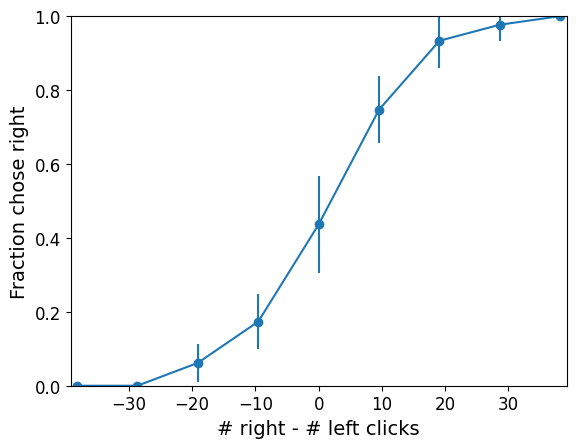

In [8]:
def plot_psychometric_curve(signal,went_right,bins=9):

  # calculate binned choice fractions
  edge = np.max(np.abs(signal))+1
  bin_edges = np.linspace(-edge,edge,bins+1)
  choice_frac = np.zeros(bins)
  n = np.zeros(bins)
  for i in range(0,bins):
    idx = (signal>bin_edges[i]) & (signal<=bin_edges[i+1])
    n[i] = np.count_nonzero(idx)
    choice_frac[i] = np.mean(went_right[idx])
  bin_mid=(bin_edges[:len(bin_edges)-1]+bin_edges[1:])/2

  # get binomial confidence intervals
  err = proportion_confint(count=n*choice_frac, nobs=n, alpha=0.05)

  # plot
  plt.figure()
  plt.errorbar(bin_mid,choice_frac,yerr=abs(err-choice_frac),marker="o")
  plt.ylim(0,1)
  plt.xlim(bin_mid[0]-1,bin_mid[-1]+1)
  plt.xlabel("# right - # left clicks")
  plt.ylabel("Fraction chose right")

plot_psychometric_curve(n_right_clicks - n_left_clicks,went_right)

<ipython-input-9-5116cbded132>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('viridis')


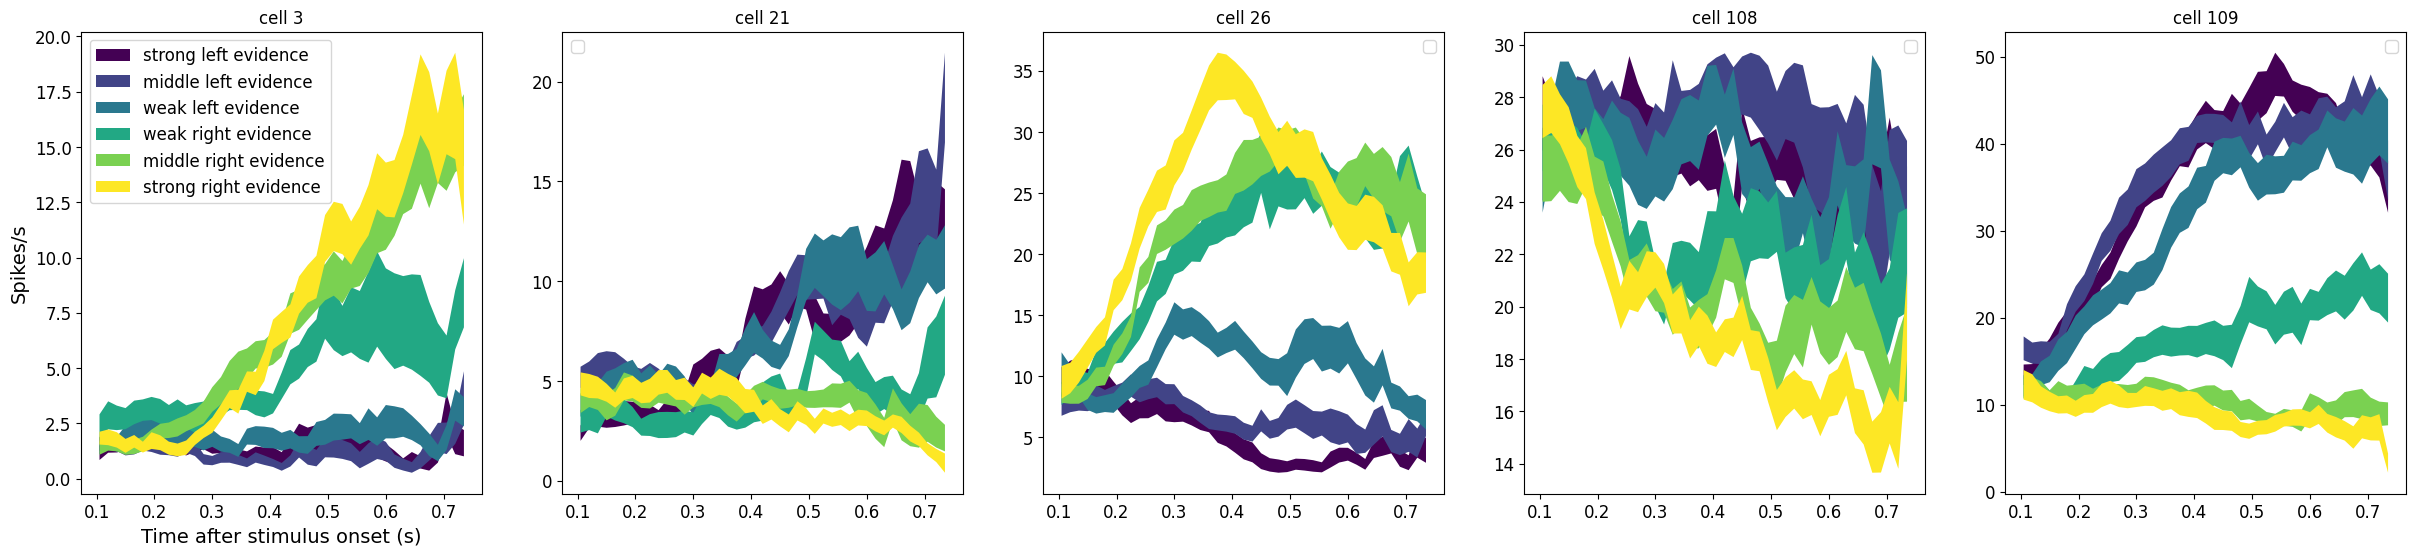

In [9]:
# define some constants needed for PETH plotting
example_cells=[3,21,26,108,109] # example choice-selective cells for T219_12_20_2019 pset1_data.mat (zero-based index)
legend_str=["strong left evidence","middle left evidence","weak left evidence","weak right evidence","middle right evidence","strong right evidence"] # trial condition names
cmap = mpl.cm.get_cmap('viridis')
colors=cmap(np.linspace(0,1,n_evidence_bins))
min_time_bin = np.count_nonzero(time_s<=time_range_s[0])
max_time_bin = np.count_nonzero(time_s<time_range_s[1])

def get_peth(response,nboot=int(1e2),q=[25,75]):
  # calculates the PETH (internal function used by plot_peth_example_cells)
  # response should be an array of size ntrials x nbins (i.e. the response of one cell for all trials and timepoints)
  # nboot defines the number of bootstrap resamples to use for calculating error bars
  # q defines the bootstrap coverage interval of the error bar in percentiles
  boots=np.empty((nboot,max_time_bin-min_time_bin))
  peth = np.empty((n_evidence_bins,max_time_bin-min_time_bin))
  peth[:] = np.nan
  lower = peth.copy()
  upper = peth.copy()
  for i in range(0,n_evidence_bins):
    trial_idx = (evidence_strength>=evidence_strength_bins[i]) & (evidence_strength<evidence_strength_bins[i+1]) & is_correct;
    this_response = response[trial_idx,min_time_bin:max_time_bin]
    ntrials=np.count_nonzero(trial_idx)
    for k in range(0,nboot):
      idx = np.random.randint(low=0, high=ntrials, size=(ntrials,));
      boots[k,:] = np.nanmean(this_response[idx,:],axis=0)
    lower[i,:]=np.percentile(boots,q[0],axis=0)
    upper[i,:]=np.percentile(boots,q[1],axis=0)
    peth[i,:] = np.nanmean(this_response,axis=0)
  return peth, lower, upper

def plot_peth(data,xlabel="Time after stimulus onset (s)", ylabel="Spikes/s", legend_str = legend_str):
  # makes a figure with a subplot for each cell,
  # illustrating its smoothed response to the stimulus,
  # with trials broken down by signal strength.
  # data is an array of size ntrials x nbins x m where m indexes cells.
  # cells indexes which cells in data to be plotted.
  xs=np.arange(min_time_bin,max_time_bin)*resolution_s
  peth,lower,upper = get_peth(data)
  plt.gca().set_prop_cycle('color',colors)
  for i in range(0,n_evidence_bins):
    plt.fill_between(xs,lower[i,:],upper[i,:])
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.legend(legend_str);

def plot_peth_example_cells(data,cells):
  # makes a figure with a subplot for each cell,
  # illustrating its smoothed response to the stimulus,
  # with trials broken down by signal strength.
  # data is an array of size ntrials x nbins x m where m indexes cells.
  # cells indexes which cells in data to be plotted.
  fig, axs = plt.subplots(1, len(cells), figsize=(30,6))
  for cellno in range(0,len(cells)):
    plt.sca(axs[cellno])
    plot_peth(np.squeeze(data[:,:,cells[cellno]]))
    axs[cellno].set_title(("cell {cellno:d}").format(cellno=cells[cellno]));
    if cellno>0:
      plt.xlabel("")
      plt.ylabel("")
      plt.legend([]);

plot_peth_example_cells(response,example_cells)

In [10]:
r_t = response.reshape((ntrials*nbins,ncells))

In [11]:
def normalize_response(response,norm_factor=5):
  # transforms input data to have zero mean and variance that scales with its normalized range (range+norm_factor)
  # increasing norm_factor will make the output less sensitive to the data range
  # approach taken from: Russo et al. (2018). Neuron.
  # response must be of size ntimepoints x ncells
  norm_response=response.copy()
  for cell in range(0,ncells): # loop over cells
    this_response = response[:,cell]
    this_response = this_response - np.nanmean(this_response); # subtract mean
    ptp = np.nanmax(this_response) - np.nanmin(this_response)
    norm_response[:,cell] = this_response/(ptp+norm_factor); # normalize variance
  return norm_response

r_t = normalize_response(r_t)
missing_rows = np.isnan(r_t[:,0])

In [12]:
from sklearn.decomposition import PCA
# Compute PCA
pca = PCA(n_components=ncells)
pca.fit(r_t[~missing_rows,:])
V = pca.components_.T


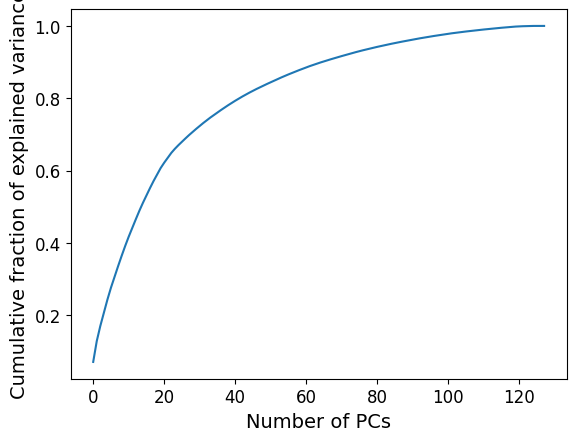

In [13]:
# Plot cumulative fraction of explained variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of PCs')
plt.ylabel('Cumulative fraction of explained variance')
plt.show()

In [14]:
# initialize s_t with NaNs
s_t = np.empty(r_t.shape)
s_t[:]=np.nan

# fill in non-missing rows with the transformed data
s_t[~missing_rows,:] = r_t[~missing_rows,:] @ V

# reshape to be size of original "response" variable (ntrials x nbins x ncells)
s_t = s_t.reshape((ntrials,nbins,ncells))

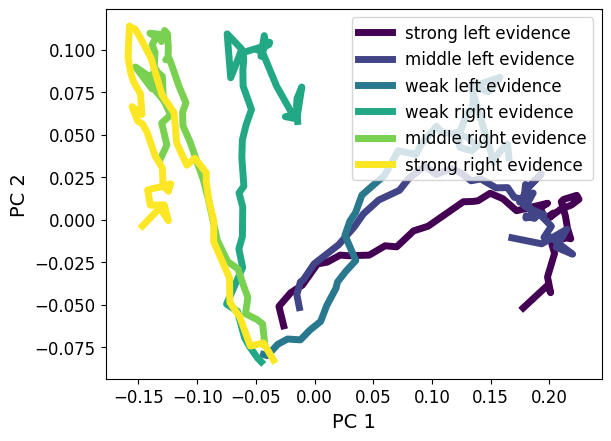

In [15]:
def plot_peth_scores_2d(s_t,PC1,PC2):
  # makes a 2d plot showing the trajectory of the population along two PCs, with trials broken down by evidence strength
  # s_t is an array of PC scores of size ntrials x nbins x npcs.
  # PC1 and PC2 are the one-based indices giving the desired pair of PCs to plot (i.e. lowest possible value is 1)
  # example: plot_peth_scores_2d(scores,1,2) will make a plot of the population trajectory across PCs 1 and 2
  peth,_,_ = get_peth(s_t[:,:,PC1-1],nboot=1)
  peth2,_,_ = get_peth(s_t[:,:,PC2-1],nboot=1)
  plt.gca().set_prop_cycle('color',colors)
  plt.plot(np.transpose(peth),np.transpose(peth2),linewidth=5)
  plt.xlabel("PC {pc:d}".format(pc=PC1))
  plt.ylabel("PC {pc:d}".format(pc=PC2))
  plt.legend(legend_str);

# plot PC 1 versus PC 2
plot_peth_scores_2d(s_t,1,2)
# plot some other PCs (use same axis range for better comparison)
# plot_peth_scores_2d(s_t,3,4)
# plot_peth_scores_2d(s_t,5,6)
# plot_peth_scores_2d(s_t,50,51)
# plot_peth_scores_2d(s_t,100,101)
# plot_peth_scores_2d(s_t,125,126)
# plot_peth_scores_2d(s_t,1,128)

In [16]:
# remove first 0.2 s from each trial of PC scores and average over time bins (hint: use np.nanmean instead of np.mean to ignore missing time bins)
s_t_average = np.nanmean(s_t[:,int(0.2/resolution_s):,:],axis=1)

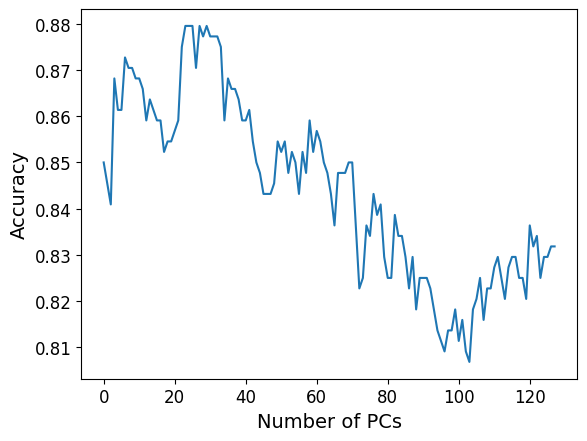

In [17]:
# import LogisticRegressionCV and turn off annoying warnings
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import KFold
from warnings import filterwarnings
filterwarnings('ignore') # suppresses the useless barage of warnings from LogisticRegressionCV

# looping over number of pcs, calculate choice prediction accuracy (under k-fold cross-validation)
K = 10;
cv_obj = KFold(n_splits=K, shuffle=True, random_state=1)
model = LogisticRegressionCV(cv=cv_obj,Cs=[float('inf')],scoring='accuracy')
accuracy=np.empty(ncells)
best_accuracy=0
for L in range(ncells):
  # fit the model (initialized above) to the animal's choices using the first L PC scores averaged across trials (i.e. the first L columns of s_t_average)
  # YOUR CODE HERE, use LogisticRegressionCV's "fit" method
  model.fit(s_t_average[:,0:L+1],went_right)
  # then calculate the cross-validated accuracy of the fitted model (code provided)
  accuracy[L]=np.mean(model.scores_[1]) # take the average accuracy across the K cros-validation folds

  # if the current value of accuracy is the best yet,
  # define best_L as the current number of PCs used
  # and define B_PCR as the current model coefficients
  if (accuracy[L] > best_accuracy):
    best_accuracy = accuracy[L]
    B_PCR = model.coef_
    best_L = L

# plot choice prediction accuracy versus number of PCs
plt.figure()
plt.plot(accuracy)
plt.xlabel('Number of PCs')
plt.ylabel('Accuracy')
plt.show()

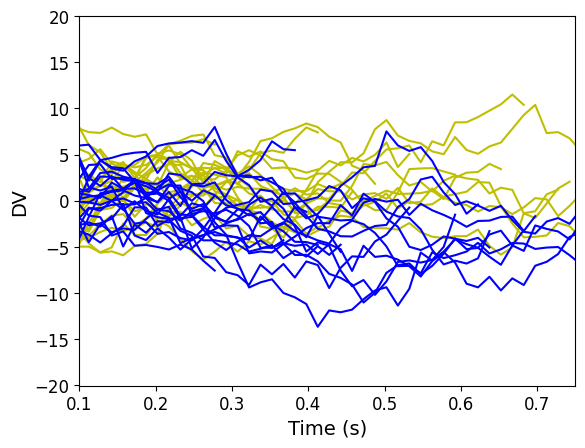

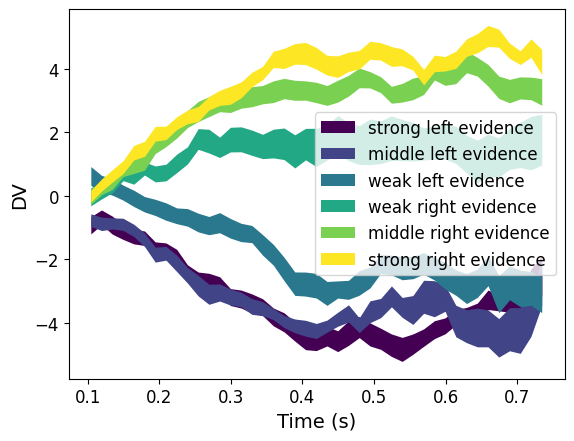

In [18]:
### Project the first L PC scores (i.e. "s_t" but including only the first L elements of its last dimension) onto the choice axis (i.e. "B_PCR") to get an estimate of the decision variable (DV_t)
### By "project A onto B" we mean "take the dot product of A and B"
B_PCR = np.squeeze(B_PCR) # np.squeeze removes singleton dimension to make B_PCR one-dimensional
DV_t = np.dot(s_t[:,:,:best_L + 1],B_PCR) # (Hint: use np.dot)

# plot decision variable trajectory on first 20 left-choice trials and first 20 right-choice trials
DV_t_left = DV_t[went_right==False,:] # get values of DV_t, selecting only the trials where the animal went left
DV_t_right = DV_t[went_right==True,:] # get values of DV_t, selecting only the trials where the animal went right
plt.figure()
plt.plot(time_s,np.transpose(DV_t_right[:20,:]),'y-');
plt.plot(time_s,np.transpose(DV_t_left[:20,:]),'b-');
plt.xlim(time_range_s)


# add x and y labels
plt.xlabel('Time (s)')
plt.ylabel('DV')
plt.show()

# plot trial-average decision variables broken down by momentary evidence strength (using function "plot_peth")
plot_peth(DV_t, xlabel = 'Time (s)', ylabel = 'DV')

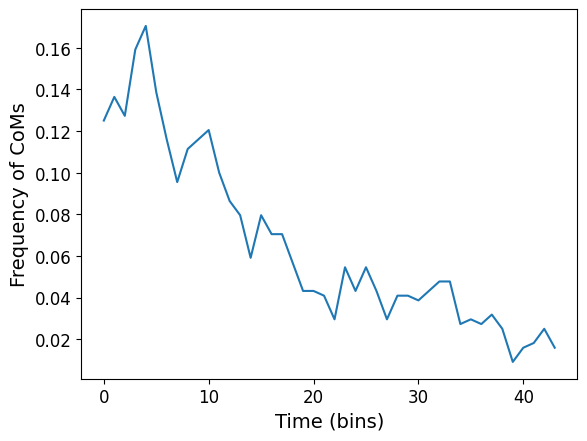

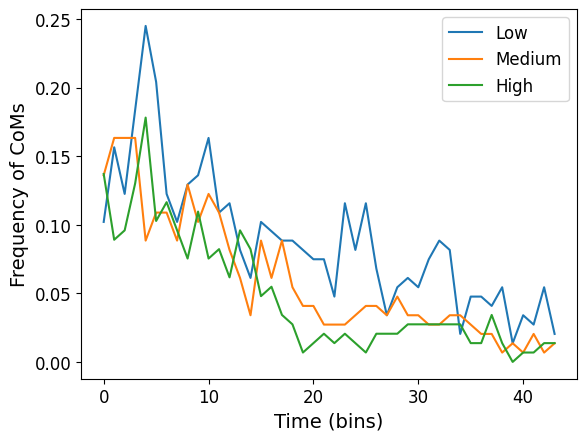

In [19]:
# index CoMs
start = int(time_range_s[0]/resolution_s)
end = int(time_range_s[1]/resolution_s)

# CoMs = np.zeros_like(DV_t[:-1, :])
# CoMs[np.diff(np.sign(DV_t), axis=0) != 0] = 1 # set to 1 if the sign changes
# print(CoMs.shape)

CoMs = np.zeros((DV_t.shape[0], end - start))
for trial in range(DV_t.shape[0]):
  for timepoint in range(start, end):
    if (DV_t[trial, timepoint] * DV_t[trial, timepoint - 1] < 0):
      CoMs[trial, timepoint - start] = 1

# plot frequency of CoMs across time bins
plt.figure()
plt.plot(CoMs.mean(axis=0))
plt.xlabel('Time (bins)')
plt.ylabel('Frequency of CoMs')
plt.show()

# plot frequency of CoMs by evidence strength
evidence_strengths = np.array_split(np.argsort(np.abs(evidence_strength)), 3)
plt.figure()
for strength in evidence_strengths:
    plt.plot(CoMs[strength, :].mean(axis=0))
plt.xlabel('Time (bins)')
plt.ylabel('Frequency of CoMs')
plt.legend(['Low', 'Medium', 'High'])
plt.show()